In [1]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc

In [2]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [8]:
def gaus_cdf(x,params):
    mean,sig = params
    return(norm.cdf(x,mean,sig))

In [3]:
def casey_2012(wave,beta,T,wave_0):
    h = 6.63E-34
    K = 1.38E-23
    c = 3E8
    freq = c/(wave*1E-6)
    print(freq)
    vo = c/(wave_0*1E-6)
    
    flux = (1 - np.exp(-(freq/vo)**beta))*(freq)**3 / (np.exp(freq*h/(K*T)) - 1)
    return(flux)

In [4]:
lofar_data = Table.read('../lofar/deep_fields/ELAIS-N1/data/data_release/lofar_XID+_merged.fits')
lofar_data[0]

id,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,MegaCam.u.res,MegaCam.u.res_err,PS1.g.res,PS1.g.res_err,PS1.r.res,PS1.r.res_err,PS1.i.res,PS1.i.res_err,PS1.z.res,PS1.z.res_err,PS1.y.res,PS1.y.res_err,HSC-g_mod.res,HSC-g_mod.res_err,HSC-r_mod.res,HSC-r_mod.res_err,HSC-i_mod.res,HSC-i_mod.res_err,HSC-z_mod.res,HSC-z_mod.res_err,HSC-Y_mod.res,HSC-Y_mod.res_err,wHSC-NB921_mod.res,wHSC-NB921_mod.res_err,UKIDSS.J.res,UKIDSS.J.res_err,UKIDSS.K.res,UKIDSS.K.res_err,IRAC.I1.res,IRAC.I1.res_err,IRAC.I2.res,IRAC.I2.res_err,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,IRAC.I3.res,IRAC.I3.res_err,IRAC.I4.res,IRAC.I4.res_err,mips_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,pacs_green,FErr_PACS_100_u,FErr_PACS_100_l,pacs_red,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,spire_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,spire_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,spire_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,redshift,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,mips_24_err,pacs_green_err,pacs_red_err,spire_250_err,spire_350_err,spire_500_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,bytes27,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,bytes6,int64,int32,float64,float64,float64,float64,float64,float64
ILTJ155957.58+550052.4,239.98990167026162,55.01456045936245,5.366954914924915e-05,8.08706707123675e-05,0.0003958345213565919,5.4160526835678236e-05,0.0003247963953282784,2.715224507873135e-05,S,0.002071920400992901,0.0016345290335764496,166.30848152559156,0.00019279093100176814,0.00012276320016402095,13.835288

In [5]:
cigale = Table.read('../lofar/deep_fields/ELAIS-N1/cigale/data/input/out/results.fits')
cigale[0]

id,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umin,bayes.dust.umin_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.attenuation.Av_BC,bayes.attenuation.Av_BC_err,bayes.attenuation.bessell_b,bayes.attenuation.bessell_b_err,bayes.attenuation.galex_fuv,bayes.attenuation.galex_fuv_err,bayes.attenuation.slope_BC,bayes.attenuation.slope_BC_err,bayes.attenuation.BC_to_ISM_factor,bayes.attenuation.BC_to_ISM_factor_err,bayes.attenuation.slope_ISM,bayes.attenuation.slope_ISM_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.MegaCam.u.res,best.PS1.g.res,best.PS1.r.res,best.PS1.i.res,best.PS1.z.res,best.PS1.y.res,best.HSC-g_mod.res,best.HSC-r_mod.res,best.HSC-i_mod.res,best.HSC-z_mod.res,best.HSC-Y_mod.res,best.wHSC-NB921_mod.res,best.UKIDSS.J.res,best.UKIDSS.K.res,best.IRAC.I1.res,best.IRAC.I2.res,best.IRAC.I3.res,best.IRAC.I4.res,best.mips_24,best.pacs_green,best.pacs_red,best.spire_250,best.spire_350,best.spire_500
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ILTJ160005.14+545029.2,81768695343.18811,15833013535.88725,65.85527866129229,9.781225601464877,2.0021545334695293e+38,3.7236893274580656e+37,2.538490105577217e+38,8.14974348114741e+37,2.983122579148215,0.6791046994815372,23.76136322517792,4.2227014758630546,0.006002616816136704,0.019880700502795015,1.2965189103770192,0.3464225451529704,0.7615126113658914,0.12127122839787843,2.1244151304315007,0.22699907995539995,-0.6999999999999998,1

In [6]:
lofar_cigale = join(lofar_data,cigale,keys='id',join_type='inner')
lofar_cigale[0]

id,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,MegaCam.u.res,MegaCam.u.res_err,PS1.g.res,PS1.g.res_err,PS1.r.res,PS1.r.res_err,PS1.i.res,PS1.i.res_err,PS1.z.res,PS1.z.res_err,PS1.y.res,PS1.y.res_err,HSC-g_mod.res,HSC-g_mod.res_err,HSC-r_mod.res,HSC-r_mod.res_err,HSC-i_mod.res,HSC-i_mod.res_err,HSC-z_mod.res,HSC-z_mod.res_err,HSC-Y_mod.res,HSC-Y_mod.res_err,wHSC-NB921_mod.res,wHSC-NB921_mod.res_err,UKIDSS.J.res,UKIDSS.J.res_err,UKIDSS.K.res,UKIDSS.K.res_err,IRAC.I1.res,IRAC.I1.res_err,IRAC.I2.res,IRAC.I2.res_err,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,IRAC.I3.res,IRAC.I3.res_err,IRAC.I4.res,IRAC.I4.res_err,mips_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,pacs_green,FErr_PACS_100_u,FErr_PACS_100_l,pacs_red,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,spire_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,spire_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,spire_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,redshift,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,mips_24_err,pacs_green_err,pacs_red_err,spire_250_err,spire_350_err,spire_500_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umin,bayes.dust.umin_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.attenuation.Av_BC,bayes.attenuation.Av_BC_err,bayes.attenuation.bessell_b,bayes.attenuation.bessell_b_err,bayes.attenuation.galex_fuv,bayes.attenuation.galex_fuv_err,bayes.attenuation.slope_BC,bayes.attenuation.slope_BC_err,bayes.attenuation.BC_to_ISM_factor,bayes.attenuation.BC_to_ISM_factor_err,bayes.attenuation.slope_ISM,bayes.attenuation.slope_ISM_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.st

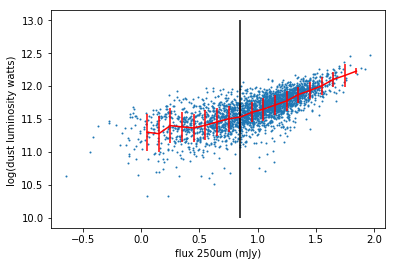

In [29]:
f250 = np.log10(lofar_cigale['spire_250'])
ldust = np.log10(lofar_cigale['bayes.dust.luminosity']/3.8E26)
plt.scatter(f250,ldust,s=1)

bins = np.arange(0.0,2.0,0.1)
x = get_center(bins)
mask = ~np.isnan(ldust)
stds,edges,_ = binned_statistic(f250[mask],ldust[mask],'std',bins=bins)
means,_,_ = binned_statistic(f250[mask],ldust[mask],'mean',bins=bins)

plt.errorbar(x,means,yerr=stds,c='red')
plt.vlines(np.log10(7),10,13)

plt.xlabel('flux 250um (mJy)')
plt.ylabel('log(dust luminosity watts) ')
plt.show()

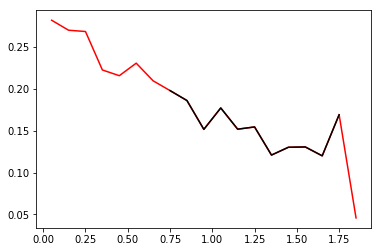

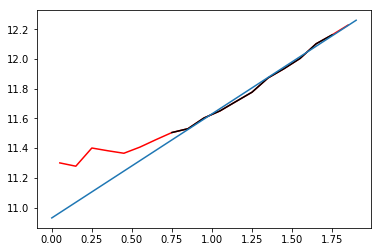

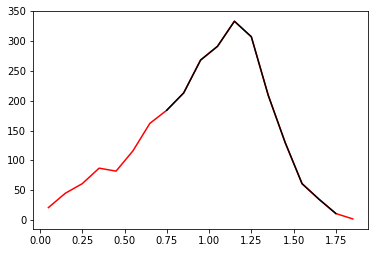

In [60]:
bins = np.arange(0.0,2.0,0.1)
x = get_center(bins)
plt.plot(x,stds,c='red')
plt.plot(x[7:len(x)-1],stds[7:len(x)-1],c='black')
plt.show()

plt.plot(x,means,c='red')
plt.plot(x[7:len(x)-1],means[7:len(x)-1],c='black')
x = np.arange(0,2,0.1)
y = 0.7*x+10.93
plt.plot(x,y)
plt.show()

bins = np.arange(0.0,2.0,0.1)
x = get_center(bins)
tots,_ = np.histogram(f250[mask],bins=bins)
plt.plot(x,tots,c='red')
plt.plot(x[7:len(x)-1],tots[7:len(x)-1],c='black')
plt.show()

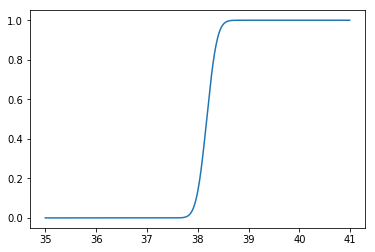

In [13]:
x = np.arange(35,41,0.01)
y = gaus_cdf(x,[means[3],stds[3]])
plt.plot(x,y)

In [82]:
spire_250_filter_wave = []
spire_250_filter = []
f = open('../../../cigalon/cigale-cigalon/database_builder/filters/spire_250.dat')
for line in f:
    if '#' in line:
        continue
    spire_250_filter_wave.append(float(line.split()[0]))
    spire_250_filter.append(float(line.split()[1]))

[3.00000000e+14 2.72727273e+14 2.50000000e+14 ... 3.00090027e+11
 3.00060012e+11 3.00030003e+11]


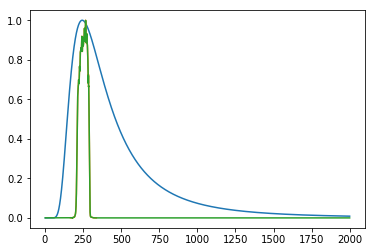

In [102]:
wave = np.arange(1,1000,0.1)
redshift = 1
wave_red = wave*(1+redshift)
flux = casey_2012(wave,1.5,30,100)*100

plt.plot(wave_red,flux/np.max(flux))

x = np.array(spire_250_filter_wave)/10**4
y = np.array(spire_250_filter)
plt.plot(x,y)

y = np.interp(wave_red,x,y)
plt.plot(wave_red,y)


tot_flux = trapz(flux,wave_red,dx=0.1)
m_250 = wave_red==250
f_250 = flux[m_250]

In [103]:
tot_flux

6.2695760407849e+39